In [1]:
# 10/03/2022 Luís

# In this notebook, in addition to the "train_HGO_diff" notebook,
# the parameters [c, κ, k1, k2, θ] were normalized using sklearn.preprocessing.StandardScaler()
# This way, each of the components of the vector is normaly distributed around 0 with a standard deviation of 1.

# For example, for c, mean = 20.59518917 and std = 12.4038047.
# A original value of 13.78172437 will be transformed into -0.54930442. (z = (x – mean) / std)

# Lower losses were achieved with this normalization.



# 28/03/2022 Luís

# In this notebook I use a total set of 537824 (14^5) curves. The model only predicts the stress value, as the stretch values
# were the same for all curves.

# In the end of the notebook, the test labels and model outputs are transformed back into absolute coordinates
# (the model is trained on the differences between stress values) and I apply evaluation metrics to the model.

# Three metrics are applied: 

# MSE (average error across all test curves)

# R^2 score (average score across all test curves)
#           (accuracy score defined as the percentage of curves that have a score above an accepteble treshold)

# Relative error (average error across all test curves)
#                (accuracy score defined as the percentage of curves that have an error below an accepteble treshold)

# I have a spreadsheet with these metrics applied on similar models which were trained on 10^5; 12^5; 14^5 and 16^5 curves.

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import ast
import seaborn as sns
from sklearn.model_selection import train_test_split

In [3]:
import pandas as pd
import random

import sympy as sym
from sympy.physics.quantum import TensorProduct

import numpy as np
from matplotlib import pyplot as plt

#pd.set_option('display.max_rows', None)

In [4]:
from sklearn import preprocessing
from sklearn.metrics import r2_score

In [5]:
def plot_the_loss_curve(epochs, mse_training, mse_validation):

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.plot(epochs[0:], mse_training[0:], label="Training Loss")
  plt.plot(epochs[0:], mse_validation[0:], label="Validation Loss")
  plt.legend()
  
  # We're not going to plot the first epoch, since the loss on the first epoch
  # is often substantially greater than the loss for other epochs.
  merged_mse_lists = mse_training[1:] + mse_validation[1:]
  highest_loss = max(merged_mse_lists)
  lowest_loss = min(merged_mse_lists)
  delta = highest_loss - lowest_loss
  print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05)
  bottom_of_y_axis = lowest_loss - (delta * 0.05)
   
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show() 

### Import data

In [6]:
df_equibiaxial = pd.read_pickle('df_equibiaxial_14_xx')

In [7]:
ninc = np.shape(df_equibiaxial['stretch'][0])[0]

In [8]:
#get number of samples
nsamples=df_equibiaxial.shape[0]
#get data channels. in this case, stretch and stress
channels = ['stretch','stress_xx']
#number of channels
nchannels=len(channels)
#number of data points
npts=ninc
# data array
y_bi=np.empty((nsamples,npts,nchannels))

for idx,signal in enumerate(channels):
    #convert signal to numpy
    s=df_equibiaxial[signal].to_numpy()
    #flatten
    s=np.concatenate(s)
    #flatten then reshape ()
    s=s.reshape(df_equibiaxial[signal].shape[0],npts)
    #append to data array
    y_bi[:,:,idx] = s

#working with X like this will be easier to handle tensor shapes during model training
#X = np.asarray(X).astype('float32')
#X=np.asarray(X.tolist())
print(nsamples,npts,nchannels)
#len(channels)

537824 20 2


In [9]:
y = y_bi

In [10]:
#features, i.e., material parameters
#features
features = ['c','κ','k1','k2','θ']
nfeatures=len(features)
# features array
X=np.empty((nsamples,nfeatures))

for idx,signal in enumerate(features):
    #convert signal to numpy
    s=df_equibiaxial[signal].to_numpy()
    #append to features array
    X[:,idx] = s #double check if it has the correct shape

#### In this case we have 537824 total curves (= 14^5)

In [11]:
#X = np.load('X_run_12_noise.npy')
#y = np.load('y_run_12_noise.npy')

In [12]:
#ninc = np.shape(y)[1] # number of points per curve, in this case ninc = 10

### Remove curves in which there are negative stress values

In [13]:
print(np.shape(y)[0], "initial total curves")

537824 initial total curves


In [14]:
y_stress = y[:,:,1]

unq, count = np.unique(np.where(y_stress>=0)[0], axis=0, return_counts=True)
i_positive = unq[count>8]

X = X[i_positive]
y = y[i_positive]

In [15]:
print(len(i_positive), "remaining curves")

537824 remaining curves


### We will normalize X now

In [16]:
print(X[0])  # Parameters for curve 0 before transformation

[19.92178319  0.32272105  4.62345312  3.32968143  4.01515236]


In [17]:
print(np.average(X, axis = 0))

[20.53305232  0.21684653  2.55514319  2.55514148 45.467038  ]


In [18]:
print(np.std(X, axis = 0))

[12.09111645  0.07219331  1.51750793  1.51732259 27.26201399]


In [19]:
# Normalization of the input data
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

In [20]:
print(X[0])  # Parameters for curve 0 after transformation

[-0.05055523  1.46654184  1.36296483  0.51046491 -1.52049976]


### Next we will transform y such that it will contain the differences between its successive elements.

In [21]:
y[0] # curve 0 before transformation

array([[ 1.        ,  0.        ],
       [ 1.03157895,  3.61083755],
       [ 1.06315789,  6.94327637],
       [ 1.09473684, 10.05964723],
       [ 1.12631579, 13.01029598],
       [ 1.15789474, 15.83715309],
       [ 1.18947368, 18.57675782],
       [ 1.22105263, 21.26301087],
       [ 1.25263158, 23.92996601],
       [ 1.28421053, 26.61506445],
       [ 1.31578947, 29.36339481],
       [ 1.34736842, 32.23388942],
       [ 1.37894737, 35.30896903],
       [ 1.41052632, 38.71025869],
       [ 1.44210526, 42.62507765],
       [ 1.47368421, 47.35237455],
       [ 1.50526316, 53.38452007],
       [ 1.53684211, 61.55683876],
       [ 1.56842105, 73.32849396],
       [ 1.6       , 91.32525234]])

In [22]:
np.shape(y)

(537824, 20, 2)

#### We will not use the stretch values in this model as input of our model. They will be saved in a vector (x_vec), as they are the same for every curve.

In [23]:
x_vec = np.array(y[0,:,0])
x_vec

array([1.        , 1.03157895, 1.06315789, 1.09473684, 1.12631579,
       1.15789474, 1.18947368, 1.22105263, 1.25263158, 1.28421053,
       1.31578947, 1.34736842, 1.37894737, 1.41052632, 1.44210526,
       1.47368421, 1.50526316, 1.53684211, 1.56842105, 1.6       ])

In [24]:
for i in range(len(y)):
    y_diff = np.zeros(np.shape(y[0]))
    for j in range(len(y[0])-1):
        y_diff[j+1] = y[i][j+1]-y[i][j]
    #y_diff[0] = [1,0]
    y[i] = y_diff

y = y[:,1:,1]
    
y[0] # curve 0 after transformation

array([ 3.61083755,  3.33243883,  3.11637086,  2.95064875,  2.82685712,
        2.73960472,  2.68625305,  2.66695514,  2.68509844,  2.74833036,
        2.87049461,  3.07507961,  3.40128966,  3.91481896,  4.7272969 ,
        6.03214552,  8.1723187 , 11.77165519, 17.99675838])

In [25]:
np.shape(y)

(537824, 19)

### Now we are ready to seperate our data into a training set and a test set

In [26]:
#let's save 10% of the data for testing. these curves won't be part of the model training 
test_split=0.1
x_train, x_test,y_train,y_test = train_test_split(X, y, test_size = test_split)
#let's check the array shapes: 
print('Input data')
print('Training set: ',x_train.shape)
print('Test set: ',x_test.shape)
print(' ')
print('Features')
print('Training set: ',y_train.shape)
print('Test set: ',y_test.shape)

#reshape for keras training
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1]))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1]))
#shuffle data
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]


Input data
Training set:  (484041, 5)
Test set:  (53783, 5)
 
Features
Training set:  (484041, 19)
Test set:  (53783, 19)


In [27]:
np.shape(x_train)

(484041, 5)

In [28]:
np.shape(y_train)

(484041, 19)

### And now we can build our model and train it

In [29]:
# Set the hyperparameters
VALIDATION_SPLIT = 0.2
LEARNING_RATE = 0.00008
BATCH_SIZE = 256
EPOCHS = 40
INPUT_SHAPE = x_train.shape[1:]
OUTPUT_SHAPE = y_train.shape[1:]

# Set the model's architechture
inputs = keras.Input(shape=INPUT_SHAPE)

dense = layers.Dense(512, activation="relu")
x = dense(inputs)

dense = layers.Dense(512, activation="relu")
x = dense(x)

dense = layers.Dense(512, activation="relu")
x = dense(x)

dropout = tf.keras.layers.Dropout(0.15)
x = dropout(x)

outputs = layers.Dense(ninc-1)(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="model")


# Compile, define the loss function, the optimizer and other metrics
model.compile(
    loss = tf.keras.losses.Huber(),
   # optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE, decay = LEARNING_RATE/EPOCHS),
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=["mean_squared_error"],
)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense (Dense)                (None, 512)               3072      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 19)                9747      
Total params: 538,131
Trainable params: 538,131
Non-trainable params: 0
_______________________________________________________

In [30]:
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

history=model.fit(
    x_train,
    y_train,
    validation_split=VALIDATION_SPLIT,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
)

test_loss, test_acc = model.evaluate(x_test, y_test)

#print("Test accuracy", test_acc)
print("Test loss", test_loss)

Epoch 1/40
1513/1513 [==============================] - 25s 15ms/step - loss: 46.6103 - mean_squared_error: 1114748.8750 - val_loss: 30.1650 - val_mean_squared_error: 856746.2500
Epoch 2/40
1513/1513 [==============================] - 21s 14ms/step - loss: 23.4131 - mean_squared_error: 648751.7500 - val_loss: 17.1073 - val_mean_squared_error: 492198.7812
Epoch 3/40
1513/1513 [==============================] - 20s 13ms/step - loss: 14.4551 - mean_squared_error: 386075.0000 - val_loss: 11.1493 - val_mean_squared_error: 300827.9375
Epoch 4/40
1513/1513 [==============================] - 23s 15ms/step - loss: 10.0684 - mean_squared_error: 248114.3906 - val_loss: 7.9722 - val_mean_squared_error: 200219.8906
Epoch 5/40
1513/1513 [==============================] - 24s 16ms/step - loss: 7.6598 - mean_squared_error: 169795.7188 - val_loss: 6.0933 - val_mean_squared_error: 136998.9375
Epoch 6/40
1513/1513 [==============================] - 20s 13ms/step - loss: 6.1345 - mean_squared_error: 12030

22.58536320924759


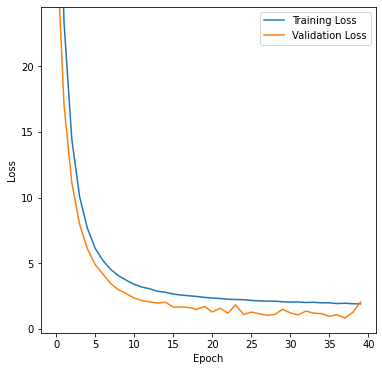

In [31]:
plt.rcParams["figure.figsize"] = (6,6)

epochs = history.epoch

hist = history.history

plot_the_loss_curve(epochs, hist["loss"], 
                    hist["val_loss"])

In [32]:
model.predict(x_test[0:1])[0]

array([3.6088266, 3.3366058, 3.119929 , 2.9501913, 2.8181717, 2.7218742,
       2.6535919, 2.6148956, 2.606705 , 2.630681 , 2.6900122, 2.8056526,
       2.974617 , 3.2286124, 3.591806 , 4.1013927, 4.841675 , 5.9556236,
       7.3917427], dtype=float32)

In [33]:
y_test[0:1][0]

array([3.36989086, 3.11445388, 2.91574555, 2.76296518, 2.64827332,
       2.56620147, 2.5132696 , 2.4877845 , 2.48981397, 2.52135366,
       2.58673143, 2.69333435, 2.85280534, 3.08295606, 3.41080689,
       3.87744184, 4.54584351, 5.51370672, 6.93471522])

In [34]:
np.shape(model.predict(x_test[0:1])[0])

(19,)

In [35]:
x_vec

array([1.        , 1.03157895, 1.06315789, 1.09473684, 1.12631579,
       1.15789474, 1.18947368, 1.22105263, 1.25263158, 1.28421053,
       1.31578947, 1.34736842, 1.37894737, 1.41052632, 1.44210526,
       1.47368421, 1.50526316, 1.53684211, 1.56842105, 1.6       ])

In [36]:
def plot_real_curves(k):
    
    pred_diff = model.predict(x_test[k:k+1])[0]
    pred = np.zeros([len(pred_diff)+1])
    pred[0] = 0
    for i in range(len(pred_diff)):
        pred[i+1] = pred_diff[i] + pred[i]

    plt.plot(x_vec,pred, "--",  color = "r", label = "prediction")

    
    true_dif = y_test[k:k+1][0]
    true = np.zeros([len(true_dif)+1])
    true[0] = 0
    for i in range(len(pred_diff)):
        true[i+1] = true_dif[i] + true[i]

    plt.plot(x_vec,true, color = "g", label = "real")

    plt.xlabel("λ")
    plt.ylabel("σ")
    plt.legend()
    plt.show()

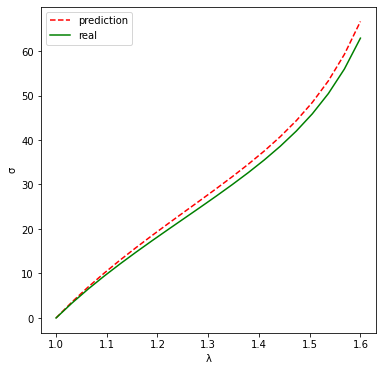

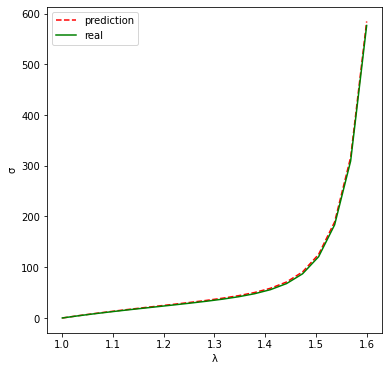

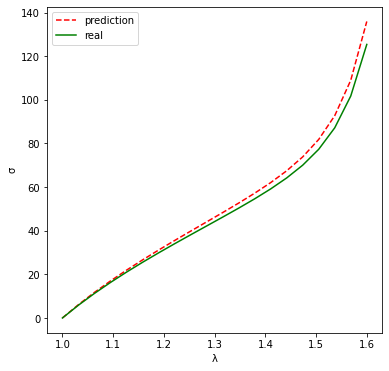

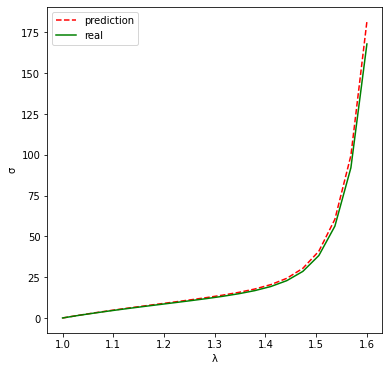

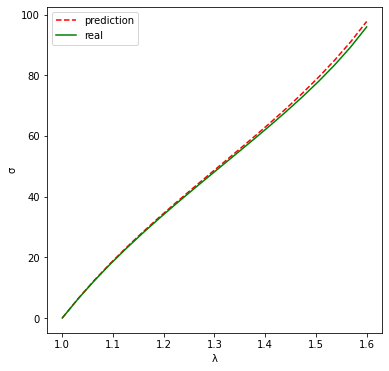

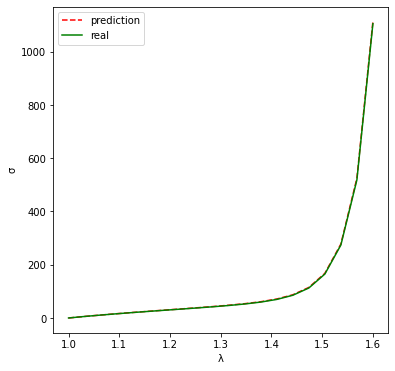

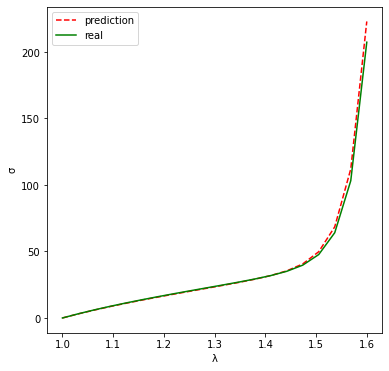

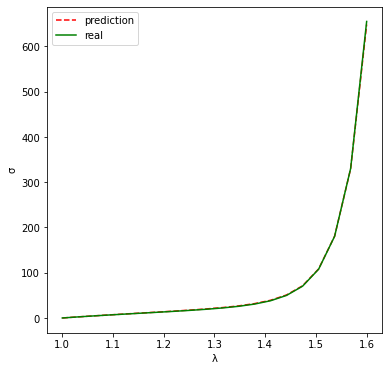

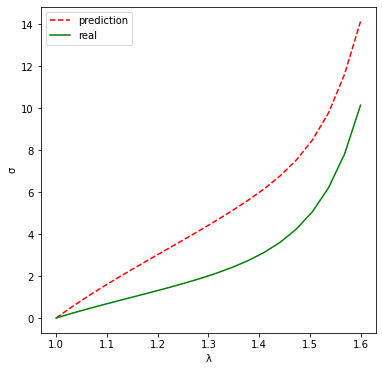

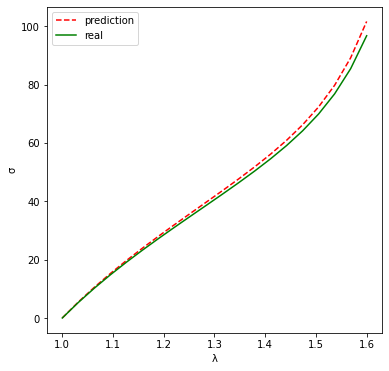

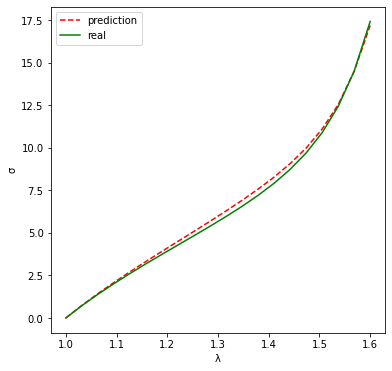

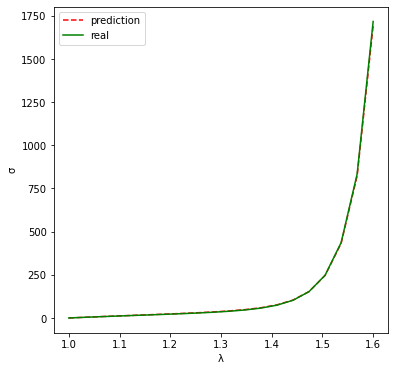

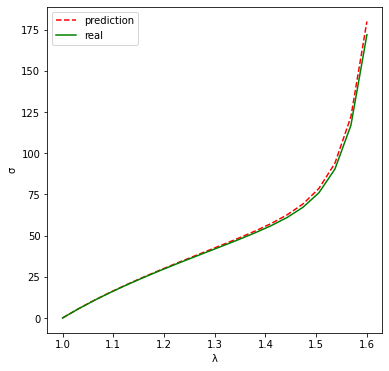

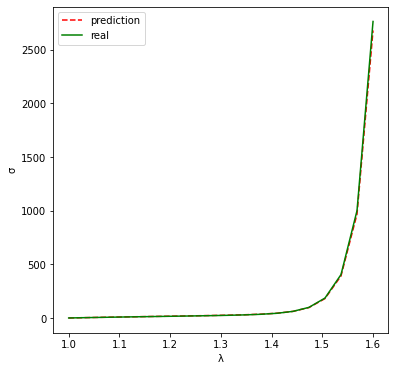

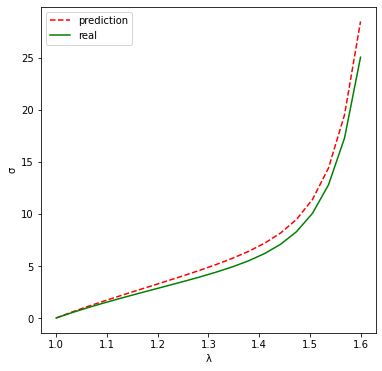

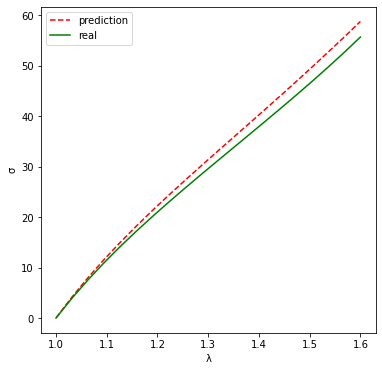

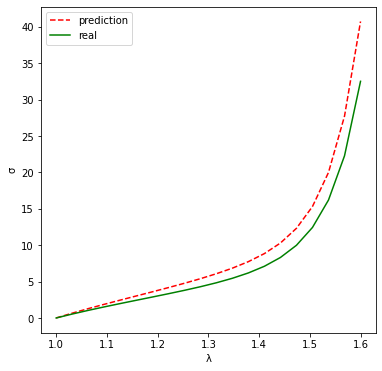

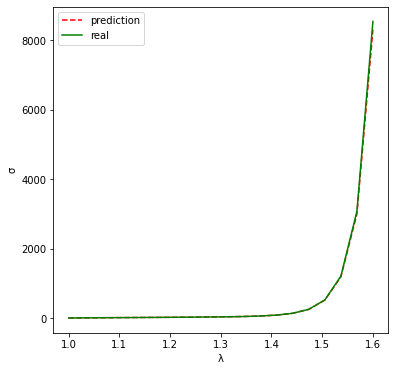

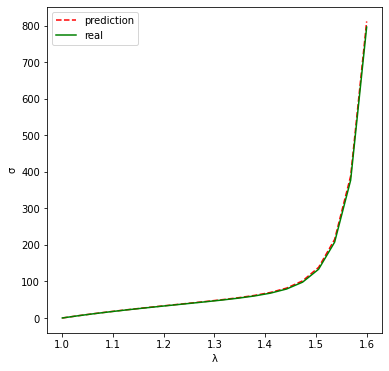

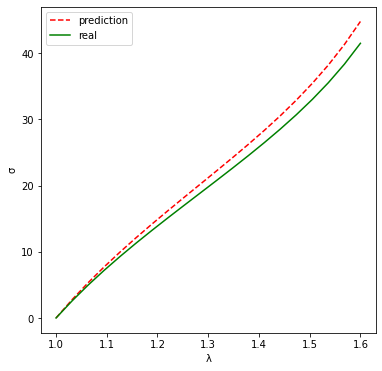

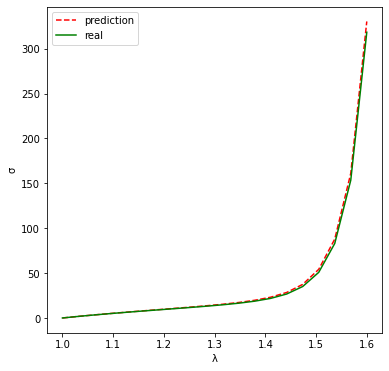

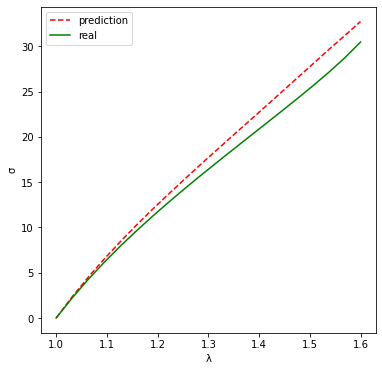

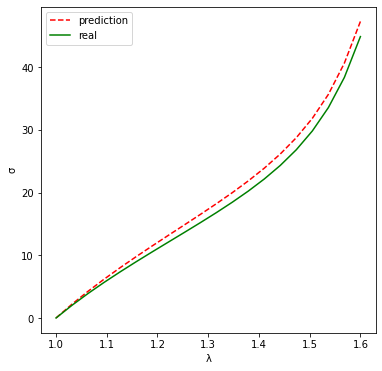

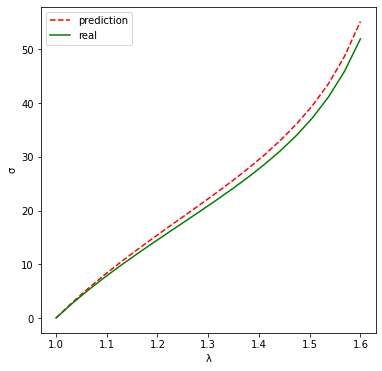

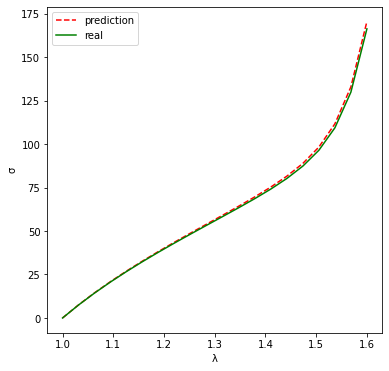

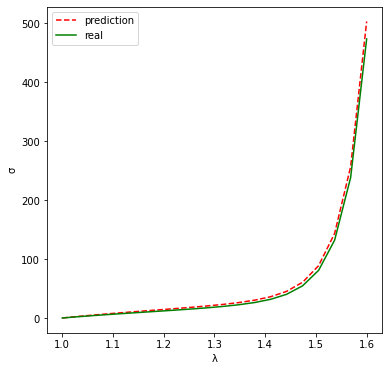

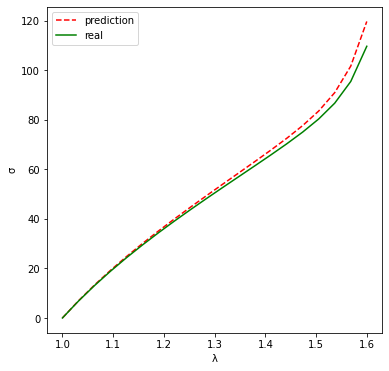

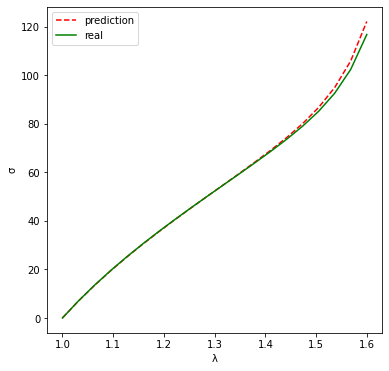

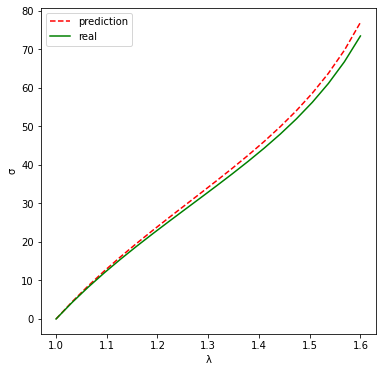

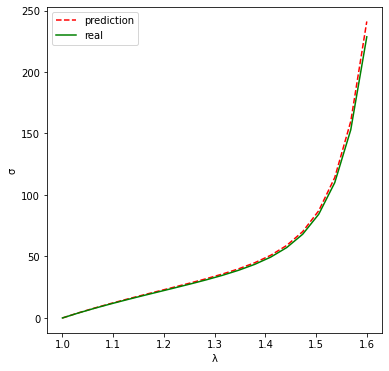

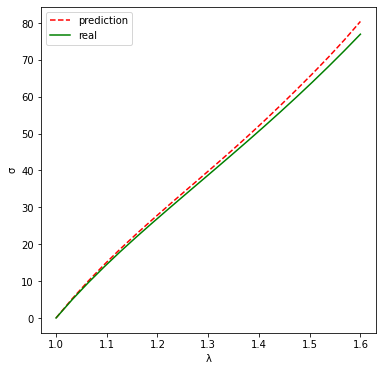

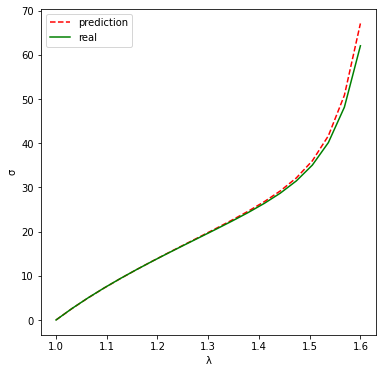

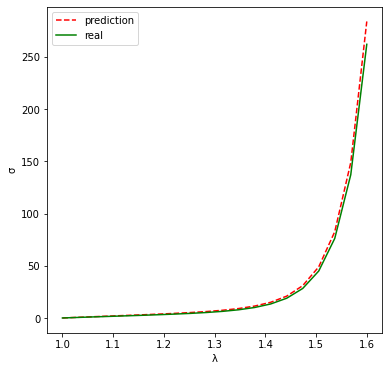

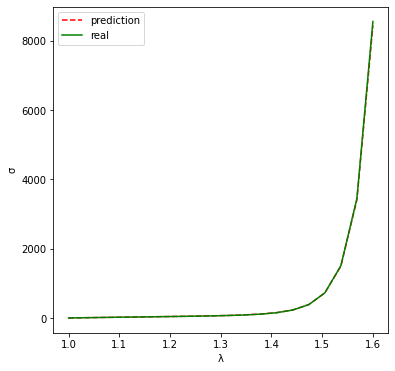

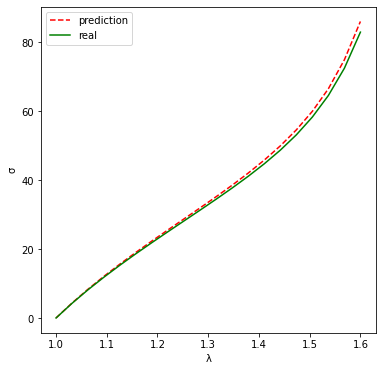

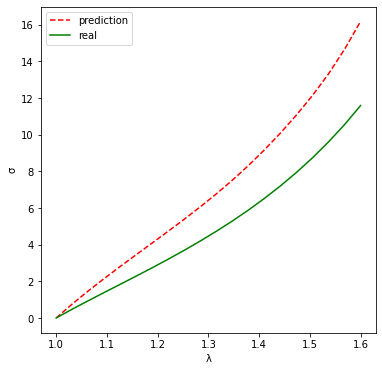

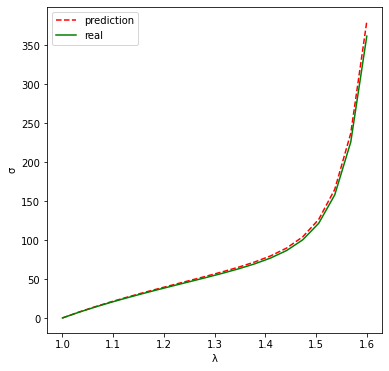

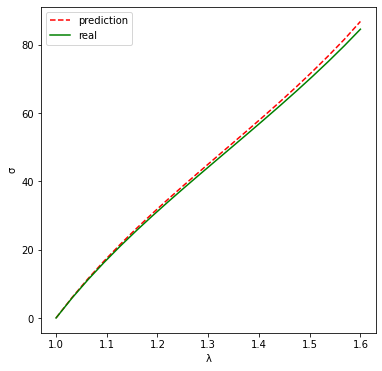

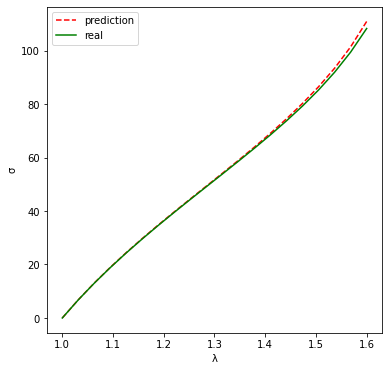

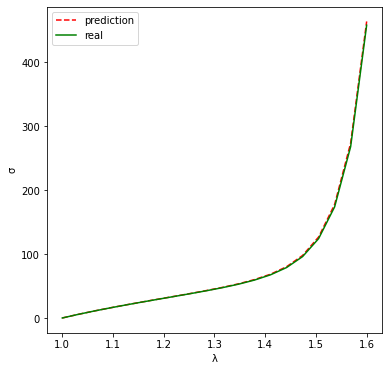

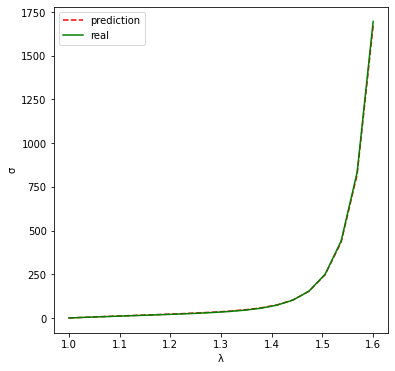

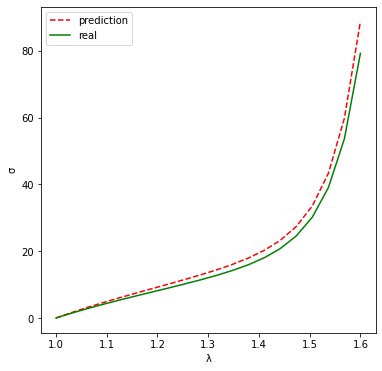

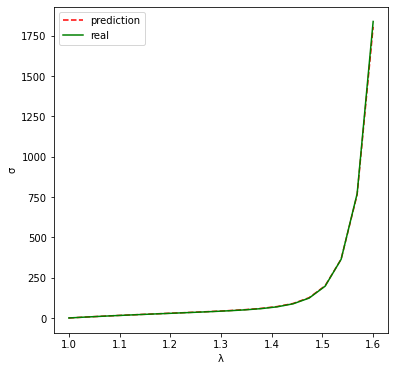

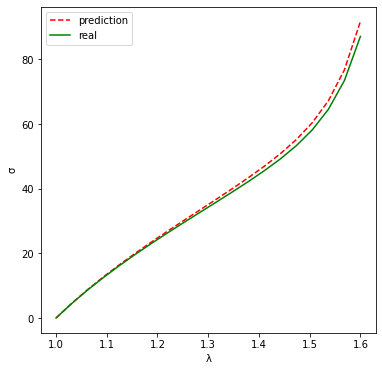

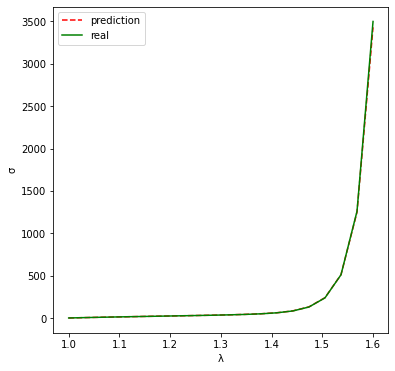

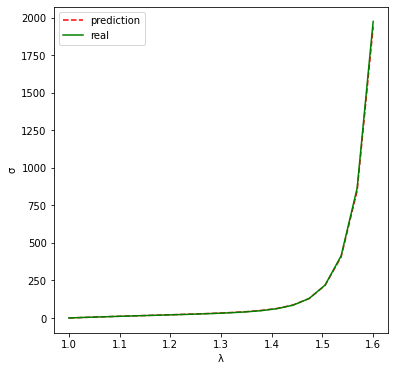

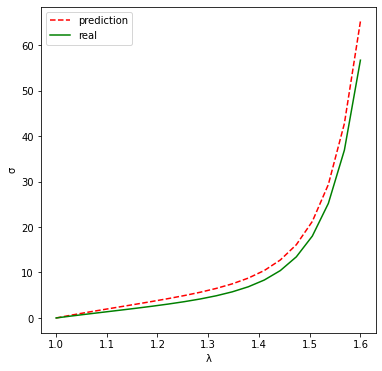

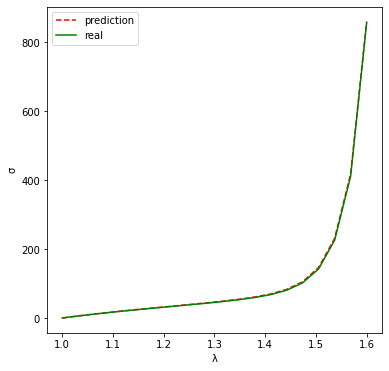

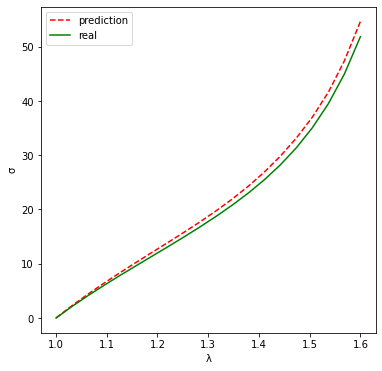

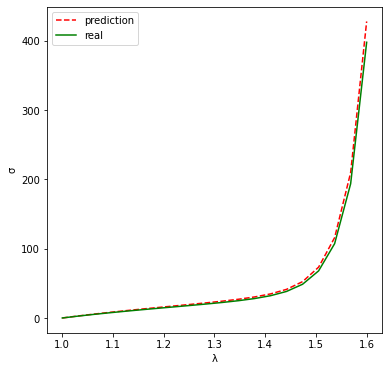

In [37]:
for i in range(50): plot_real_curves(i)

In [38]:
def rel_error(true,guess):
    err = np.abs(true-guess)/np.abs(true)
    return err

### Convert the curves used for testing back into absolute coordinates

In [39]:
def convert_back_curves(y_diff):
    ### Transforms the model's output (which is written in terms of differences between points) back into absolute coordinates.
    
    abs_curves = np.zeros([np.shape(y_diff)[0],np.shape(y_diff)[1]+1])    
    for i in range(len(y_diff)):
        y_abs = np.zeros(np.shape(y_diff)[1]+1)
        for j in range(len(y_diff[0])):
            y_abs[j+1] = y_diff[i][j]+y_abs[j]
        abs_curves[i] = y_abs
    
    return abs_curves

In [40]:
pred_curves = convert_back_curves(model.predict(x_test))
true_curves = convert_back_curves(y_test)

### Model evaluation metrics applied on the test set of curves

In [41]:
# RELATIVE ERROR CRITERIA
c = np.average(rel_error(true_curves[:,1:], pred_curves[:,1:]),axis = 1)

print("Average relative error", np.round(np.average(c)*100,decimals = 2),"%")

treshold = 0.05
print("Relative error accuracy =",np.round(100*len(c[c<treshold])/len(c), decimals = 2),"%, for a treshold of",treshold*100,"%")
print('\n')

# R^2 SCORE CRITERIA
d = r2_score(np.transpose(true_curves[:,1:]), np.transpose(pred_curves[:,1:]), multioutput='raw_values')

print("Average R^2 score: ", np.round(np.average(d),decimals = 4))

treshold = 0.95
print("R^2 Accuracy =", np.round(100*len(d[d>treshold])/len(d),decimals=2), "%, for a treshold of", treshold)
print('\n')

# MSE CRITERIA
mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
e = mse(true_curves[:,1:], pred_curves[:,1:]).numpy()

print("Average MSE score: ", np.round(np.average(e),decimals = 2),'\n')

print("Average RMSE score: ", np.round(np.sqrt(np.average(e)),decimals=2),'\n')

# MAE CRITERIA
mae = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)
f = mae(true_curves[:,1:], pred_curves[:,1:]).numpy()

print("Average MAE score: ", np.round(np.average(f),decimals = 2),'\n')

Average relative error 11.71 %
Relative error accuracy = 57.67 %, for a treshold of 5.0 %


Average R^2 score:  0.7751
R^2 Accuracy = 89.49 %, for a treshold of 0.95


Average MSE score:  10565.03 

Average RMSE score:  102.79 

Average MAE score:  4.31 



### Best and worst curves according to each criteria

Curve nº: 43640 . Worst curve by relative error criteria


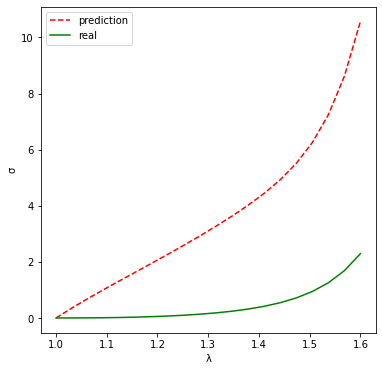

In [42]:
print("Curve nº:", np.argmax(c), ". Worst curve by relative error criteria")
plot_real_curves(np.argmax(c))

Curve nº: 44694 . Best curve by relative error criteria


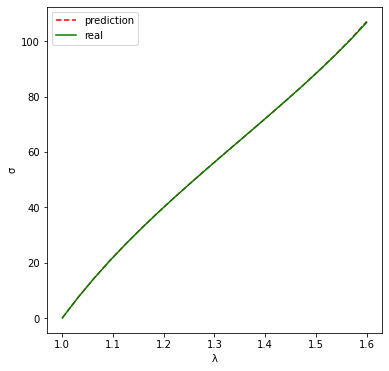

In [43]:
print("Curve nº:", np.argmin(c), ". Best curve by relative error criteria")
plot_real_curves(np.argmin(c))

Curve nº: 2827 . Worst curve by R^2 criteria


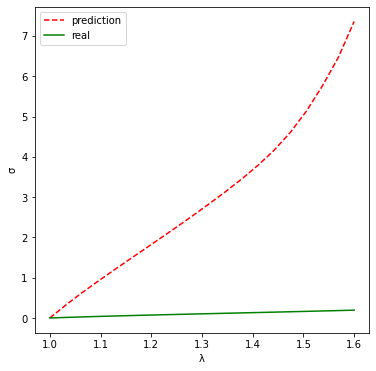

In [44]:
print("Curve nº:", np.argmin(d), ". Worst curve by R^2 criteria")
plot_real_curves(np.argmin(d))

Curve nº: 7257 . Best curve by R^2 criteria


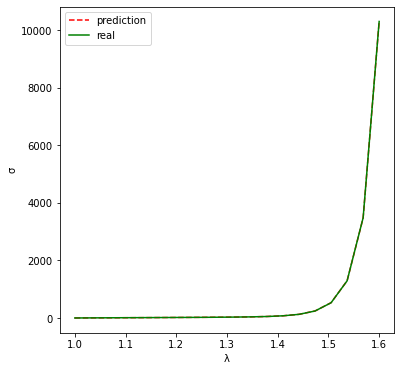

In [45]:
print("Curve nº:", np.argmax(d), ". Best curve by R^2 criteria")
plot_real_curves(np.argmax(d))

Curve nº: 49174 . Worst curve by MSE criteria


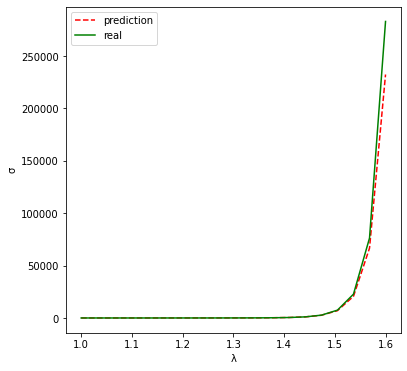

In [46]:
print("Curve nº:", np.argmax(e), ". Worst curve by MSE criteria")
plot_real_curves(np.argmax(e))

Curve nº: 22724 . Best curve by MSE criteria


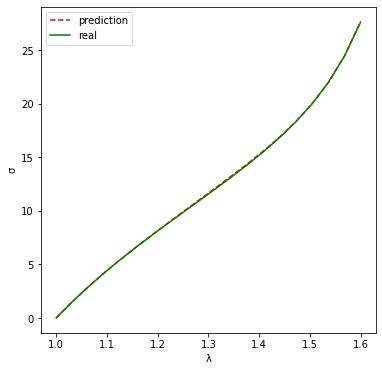

In [47]:
print("Curve nº:", np.argmin(e), ". Best curve by MSE criteria")
plot_real_curves(np.argmin(e))

Curve nº: 49174 . Worst curve by MAE criteria


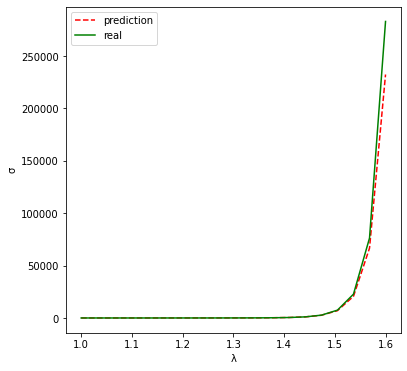

In [48]:
print("Curve nº:", np.argmax(f), ". Worst curve by MAE criteria")
plot_real_curves(np.argmax(f))

Curve nº: 22724 . Best curve by MAE criteria


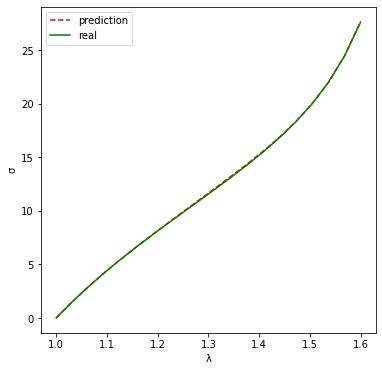

In [49]:
print("Curve nº:", np.argmin(f), ". Best curve by MAE criteria")
plot_real_curves(np.argmin(f))

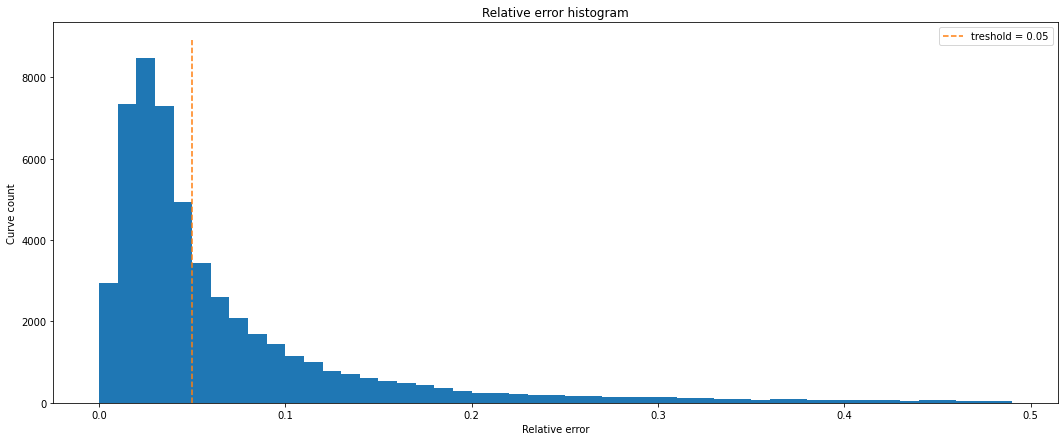

In [50]:
BINS = np.arange(0,0.5,0.01)

plt.rcParams["figure.figsize"] = (18,7)
fig=plt.hist(c, bins = BINS,rwidth=1)

m = np.max(np.histogram(c, bins = BINS)[0]) + 0.05*np.max(np.histogram(c, bins = BINS)[0])

plt.plot([0.05,0.05],[0,m], '--', label = "treshold = 0.05")

plt.ylabel("Curve count")
plt.xlabel("Relative error")
plt.title("Relative error histogram")

plt.legend()
plt.show()

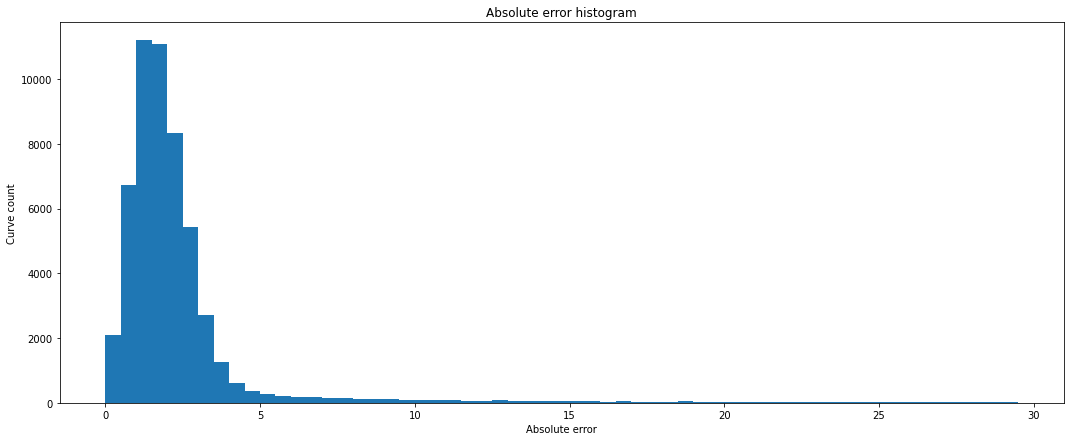

In [53]:
BINS = np.arange(0,30.0,0.5)

plt.rcParams["figure.figsize"] = (18,7)
fig=plt.hist(f, bins = BINS,rwidth=1)

plt.ylabel("Curve count")
plt.xlabel("Absolute error")
plt.title("Absolute error histogram")

plt.show()